In [132]:
from dotenv import load_dotenv

load_dotenv()

True

In [133]:
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from typing import Literal

In [134]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["munich"]:
        return "It's 15 degrees Celsius and cloudy."
    else:
        return "It's 32 degrees Celsius and sunny."

In [135]:
get_weather.invoke(input={"location": "munich"})

"It's 15 degrees Celsius and cloudy."

In [136]:
get_weather.invoke(input={"location": "chicago"})

"It's 32 degrees Celsius and sunny."

In [137]:
tools = [get_weather]
model = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)

In [138]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

import os
google_api_key=os.getenv("GEMINI_API_KEY")

from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite-preview-06-17",  # or another model like "gemini-1.5-pro"
    temperature=0.5,
    google_api_key = google_api_key
)
tools = [get_weather]

model = model.bind_tools(tools)

model.invoke("Hello!! Who are you?")

AIMessage(content='I am a large language model, trained by Google.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-fb85ddd8-03a5-45c2-bae4-9a01de9ef183-0', usage_metadata={'input_tokens': 46, 'output_tokens': 11, 'total_tokens': 57, 'input_token_details': {'cache_read': 0}})

In [139]:
model.invoke("hello")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-3a351e5d-369b-4561-aef6-d1f9ea5d49dc-0', usage_metadata={'input_tokens': 41, 'output_tokens': 9, 'total_tokens': 50, 'input_token_details': {'cache_read': 0}})

In [140]:
model.invoke("Hi, what is S&P Global stock price?")

AIMessage(content='I do not have the ability to look up stock prices. I can provide you with weather information.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-cb42c4ee-7c80-49e6-9915-6cdefc81dd94-0', usage_metadata={'input_tokens': 51, 'output_tokens': 20, 'total_tokens': 71, 'input_token_details': {'cache_read': 0}})

In [141]:
model.invoke("How is the weather in munich?")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "munich"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-2bfea393-0c11-457e-95a1-5b1dc2337265-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'munich'}, 'id': '184e3592-55b1-43b6-b825-41ac015cb1ee', 'type': 'tool_call'}], usage_metadata={'input_tokens': 48, 'output_tokens': 16, 'total_tokens': 64, 'input_token_details': {'cache_read': 0}})

In [142]:
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [143]:
workflow = StateGraph(MessagesState)
tool_node = ToolNode(tools)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

In [144]:
workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

In [145]:
graph = workflow.compile()

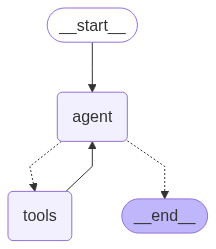

In [146]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [147]:
runnable = workflow.compile()

output = runnable.invoke({
    "messages": [HumanMessage(content="Hi, who is ambani"),]
})

for m in output["messages"]:
    print(m.content)


Hi, who is ambani
I am sorry, I cannot help with that. My capabilities are limited to providing information about the weather.


In [148]:
from langchain_core.messages import HumanMessage

messages1 = [HumanMessage(content="Hello, how are you?")]
messages2 = [HumanMessage(content="How is the weather in munich?")]
messages3 = [HumanMessage(content="What would you recommend to do in that city than?")]

In [149]:
graph.invoke({"messages": messages1})

{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='b579ad14-7e6b-470a-ab99-8f0f0ef8d551'),
  AIMessage(content="Hello! I'm doing well, thank you for asking. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-547c5f97-e6de-4a74-a8a6-915649ef2ea8-0', usage_metadata={'input_tokens': 46, 'output_tokens': 20, 'total_tokens': 66, 'input_token_details': {'cache_read': 0}})]}

In [150]:
graph.invoke({"messages": messages2})

{'messages': [HumanMessage(content='How is the weather in munich?', additional_kwargs={}, response_metadata={}, id='57d2e67a-3643-460a-b08e-760bf9c57391'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "munich"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-35425e91-9aa9-4ef5-bf0e-4b2e3fc2b190-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'munich'}, 'id': '7181ea49-bf69-4597-88e0-c610a3f61169', 'type': 'tool_call'}], usage_metadata={'input_tokens': 48, 'output_tokens': 16, 'total_tokens': 64, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="It's 15 degrees Celsius and cloudy.", name='get_weather', id='5bdcb732-5ef9-4eca-84b4-777eb9de2232', tool_call_id='7181ea49-bf69-4597-88e0-c610a3f61169'),
  AIMessage(content="It's 15 degrees Celsius and cloudy.", additional_kwargs={}, response_metadata={'prom

In [151]:
graph.invoke({"messages": messages3})

{'messages': [HumanMessage(content='What would you recommend to do in that city than?', additional_kwargs={}, response_metadata={}, id='9f246a9f-ae31-4a5b-903e-57576c1a9736'),
  AIMessage(content='I need to know which city you are referring to before I can make recommendations. Can you please tell me the city name?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-b2170ba3-9749-4117-9eea-53888c51d5fb-0', usage_metadata={'input_tokens': 51, 'output_tokens': 25, 'total_tokens': 76, 'input_token_details': {'cache_read': 0}})]}

In [152]:
graph.invoke(
    {
        "messages": [
            HumanMessage(content="What would you recommend to do in that city than?")
        ]
    }
)

{'messages': [HumanMessage(content='What would you recommend to do in that city than?', additional_kwargs={}, response_metadata={}, id='74caff34-2063-4e1e-b1b1-5c33853f4670'),
  AIMessage(content='I need to know which city you are referring to before I can make recommendations. Can you please tell me the city name?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-a3c0a227-ff71-43df-bc18-b8115bfc970d-0', usage_metadata={'input_tokens': 51, 'output_tokens': 25, 'total_tokens': 76, 'input_token_details': {'cache_read': 0}})]}

### Add Memory to chatbot

In [153]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

In [154]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile(checkpointer=checkpointer)

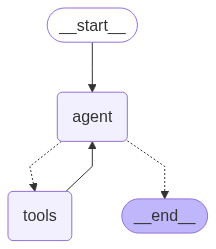

In [160]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [155]:
graph.invoke(
    {"messages": [HumanMessage(content="How is the weather in munich?")]},
    config={"configurable": {"thread_id": 1}},
)

{'messages': [HumanMessage(content='How is the weather in munich?', additional_kwargs={}, response_metadata={}, id='92f1586c-a6c3-4166-bfc0-9480c1830c36'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "munich"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f8427cf9-64b5-4cb2-95ae-3de65c959fc2-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'munich'}, 'id': '9e0d4f2f-c87d-4be3-a798-4f96fdbe015d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 48, 'output_tokens': 16, 'total_tokens': 64, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="It's 15 degrees Celsius and cloudy.", name='get_weather', id='0ad90faf-f16b-4aea-b5a1-679c53dac4ae', tool_call_id='9e0d4f2f-c87d-4be3-a798-4f96fdbe015d'),
  AIMessage(content="It's 15 degrees Celsius and cloudy.", additional_kwargs={}, response_metadata={'prom

In [156]:
graph.invoke(
    {
        "messages": [
            HumanMessage(content="What would you recommend to do in that city than?")
        ]
    }
    ,config={"configurable": {"thread_id": 1}},
)

{'messages': [HumanMessage(content='How is the weather in munich?', additional_kwargs={}, response_metadata={}, id='92f1586c-a6c3-4166-bfc0-9480c1830c36'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "munich"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f8427cf9-64b5-4cb2-95ae-3de65c959fc2-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'munich'}, 'id': '9e0d4f2f-c87d-4be3-a798-4f96fdbe015d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 48, 'output_tokens': 16, 'total_tokens': 64, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="It's 15 degrees Celsius and cloudy.", name='get_weather', id='0ad90faf-f16b-4aea-b5a1-679c53dac4ae', tool_call_id='9e0d4f2f-c87d-4be3-a798-4f96fdbe015d'),
  AIMessage(content="It's 15 degrees Celsius and cloudy.", additional_kwargs={}, response_metadata={'prom

In [157]:
graph.invoke(
    {"messages": [HumanMessage(content="What is that city famous for?")]},
    config={"configurable": {"thread_id": 1}},
)

{'messages': [HumanMessage(content='How is the weather in munich?', additional_kwargs={}, response_metadata={}, id='92f1586c-a6c3-4166-bfc0-9480c1830c36'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "munich"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f8427cf9-64b5-4cb2-95ae-3de65c959fc2-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'munich'}, 'id': '9e0d4f2f-c87d-4be3-a798-4f96fdbe015d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 48, 'output_tokens': 16, 'total_tokens': 64, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="It's 15 degrees Celsius and cloudy.", name='get_weather', id='0ad90faf-f16b-4aea-b5a1-679c53dac4ae', tool_call_id='9e0d4f2f-c87d-4be3-a798-4f96fdbe015d'),
  AIMessage(content="It's 15 degrees Celsius and cloudy.", additional_kwargs={}, response_metadata={'prom

In [158]:
graph.invoke(
    {"messages": [HumanMessage(content="When is that city founded?")]},
    config={"configurable": {"thread_id": 1}},
)

{'messages': [HumanMessage(content='How is the weather in munich?', additional_kwargs={}, response_metadata={}, id='92f1586c-a6c3-4166-bfc0-9480c1830c36'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "munich"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f8427cf9-64b5-4cb2-95ae-3de65c959fc2-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'munich'}, 'id': '9e0d4f2f-c87d-4be3-a798-4f96fdbe015d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 48, 'output_tokens': 16, 'total_tokens': 64, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="It's 15 degrees Celsius and cloudy.", name='get_weather', id='0ad90faf-f16b-4aea-b5a1-679c53dac4ae', tool_call_id='9e0d4f2f-c87d-4be3-a798-4f96fdbe015d'),
  AIMessage(content="It's 15 degrees Celsius and cloudy.", additional_kwargs={}, response_metadata={'prom

In [159]:
graph.invoke(
    {"messages": [HumanMessage(content="What is the time in that city?")]},
    config={"configurable": {"thread_id": 1}},
)

{'messages': [HumanMessage(content='How is the weather in munich?', additional_kwargs={}, response_metadata={}, id='92f1586c-a6c3-4166-bfc0-9480c1830c36'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "munich"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f8427cf9-64b5-4cb2-95ae-3de65c959fc2-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'munich'}, 'id': '9e0d4f2f-c87d-4be3-a798-4f96fdbe015d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 48, 'output_tokens': 16, 'total_tokens': 64, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="It's 15 degrees Celsius and cloudy.", name='get_weather', id='0ad90faf-f16b-4aea-b5a1-679c53dac4ae', tool_call_id='9e0d4f2f-c87d-4be3-a798-4f96fdbe015d'),
  AIMessage(content="It's 15 degrees Celsius and cloudy.", additional_kwargs={}, response_metadata={'prom